In [1]:
from calculate_score import PerformanceAnalyzer
from utils import df_to_prediction_handler

from sklearn.linear_model import RidgeCV

from collections import defaultdict

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

%matplotlib inline

In [2]:
# Inputs:
val_preds_file = "../data/inferenced_outpus/val_merged.csv"
test_preds_file = "../data/inferenced_outpus/test_merged.csv"

In [3]:
ordered_columns = ["user_id", "movie_id", "y_true", "CF_Item", "CF_User", "LFM", "CB_Plot", "CB_Poster", "CB_Metadata"]

# Load validation preds df:
val_preds_df_orig = pd.read_csv(val_preds_file)[ordered_columns]
test_preds_df_orig = pd.read_csv(test_preds_file)[ordered_columns]

# These are the features
orig_col_names = ["user_id", "movie_id", "y_true", "CF_Item", "CF_User", "LFM", "CB_Plot", "CB_Poster", "CB_Metadata"]
model_col_names_orig = ["CF_Item", "CF_User", "LFM", "CB_Plot", "CB_Poster", "CB_Metadata"]
model_col_names = ["CF_Item", "CF_User", "LFM", "CB_Plot", "CB_Poster", "CB_Metadata"]

# 'y_true' is the ground-truth.
# index (key) = (user_id, movie_id)

# Pre-analysis: Building Aspect based getter functions.

In [4]:
ratings_mat_train_file = "../data/rating_mats/ratings_mat_train.pickle"

with open(ratings_mat_train_file, "rb") as fp:
    ratings_mat_train = pickle.load(fp)

inv_ratings_mat_train = defaultdict(dict)
for user_id, item_ratings in ratings_mat_train.items():
    for item_id, rating in item_ratings.items():
        inv_ratings_mat_train[item_id][user_id] = rating


##### Aspect: User (Percentile)

count    270646.000000
mean         91.348385
std         195.506129
min           1.000000
25%          14.000000
50%          28.000000
75%          88.000000
max       17384.000000
Name: num_movies, dtype: float64

Use func: get_user_aspect_qcut(row).


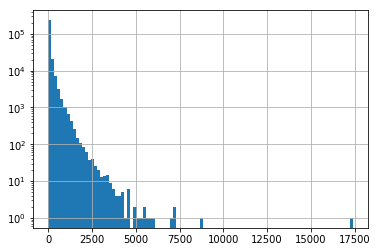

In [5]:
def get_user_aspect_func():
    user_ids = []
    num_movies = []
    for user_id, item_ratings in ratings_mat_train.items():
        user_ids.append(user_id)
        num_movies.append(len(item_ratings))

    user_aspect_counts = pd.DataFrame({"user_id": user_ids, "num_movies": num_movies})
    print(user_aspect_counts.num_movies.describe())
    plt.yscale('log')
    user_aspect_counts.num_movies.hist(bins=100)

    user_aspect_counts['qcut_label'] = pd.qcut(user_aspect_counts.num_movies.rank(method='first'), 10, labels=False)
    user_aspect_counts = user_aspect_counts.set_index("user_id")

    #def get_user_aspect_qcut(user_id):
    #    return user_aspect_counts.loc[user_id]['qcut_label']

    def get_user_aspect_qcut(row):
        return user_aspect_counts.loc[row['user_id']]['qcut_label']
    
    print("\nUse func: get_user_aspect_qcut(row).")
    return get_user_aspect_qcut


get_user_aspect_qcut = get_user_aspect_func()

##### Aspect: Movie (Percentile)

count    44759.000000
mean       552.359861
std       2896.279995
min          1.000000
25%          2.000000
50%          8.000000
75%         67.000000
max      87416.000000
Name: num_users, dtype: float64

Use func: get_movie_aspect_qcut(row).


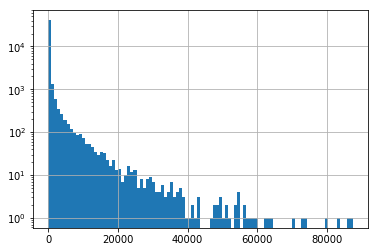

In [6]:
def get_movie_aspect_func():
    movie_ids = []
    num_users = []

    for movie_id, user_ratings in inv_ratings_mat_train.items():
        movie_ids.append(movie_id)
        num_users.append(len(user_ratings))

    movie_aspect_counts = pd.DataFrame({"movie_id": movie_ids, "num_users": num_users})
    print(movie_aspect_counts.num_users.describe())
    plt.yscale('log')
    movie_aspect_counts.num_users.hist(bins=100)

    movie_aspect_counts['qcut_label'] = pd.qcut(movie_aspect_counts.num_users.rank(method='first'), 10, labels=False)
    movie_aspect_counts = movie_aspect_counts.set_index("movie_id")

    #def get_movie_aspect_qcut(movie_id):
    #    return movie_aspect_counts.loc[movie_id]['qcut_label']

    def get_movie_aspect_qcut(row):
        return movie_aspect_counts.loc[row['movie_id']]['qcut_label']
    
    print("\nUse func: get_movie_aspect_qcut(row).")
    return get_movie_aspect_qcut


get_movie_aspect_qcut = get_movie_aspect_func()

##### TODO: Aspect: Genre (categorical)

In [8]:
def get_genre_aspect_func(movie_to_genre_dict):
    def get_genre_aspect_qcut(row):
        movie_id = row['movie_id']
        if movie_id not in movie_to_genre_dict:
            return None
        else:
            return movie_to_genre_dict[movie_id]

    print("\nUse func: get_genre_aspect_qcut(row).")
    return get_genre_aspect_qcut


movie_to_genre_pickle_file = "../data/movies_genres.pickle"
with open(movie_to_genre_pickle_file, "rb") as fp:
    movie_to_genre_dict = pickle.load(fp)

unique_genres = set(movie_to_genre_dict.values())
genre_qcut_values = unique_genres
get_genre_aspect_qcut = get_genre_aspect_func(movie_to_genre_dict)


Use func: get_genre_aspect_qcut(row).


##### TODO: Aspect: Top Actors (Quantile)

count    44711.000000
mean         0.596140
std          1.102289
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         21.000000
Name: num_topactors, dtype: float64

Use func: get_topactors_aspect_qcut(row).


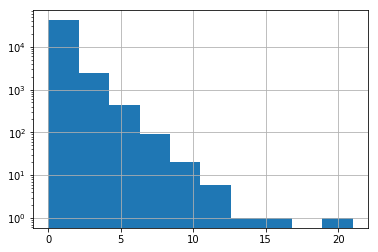

In [9]:
def get_topactors_aspect_func(actors_one_hot_embeddings):
    movie_ids = []
    num_topactors = []

    for movie_id, onehot_encoding in actors_one_hot_embeddings.items():
        movie_ids.append(movie_id)
        num_topactors.append(np.sum(onehot_encoding.ravel()))

    topactors_aspect_counts = pd.DataFrame({"movie_id": movie_ids, "num_topactors": num_topactors})
    print(topactors_aspect_counts.num_topactors.describe())
    plt.yscale('log')
    topactors_aspect_counts.num_topactors.hist()

    topactors_aspect_counts['qcut_label'] = pd.qcut(topactors_aspect_counts.num_topactors.rank(method='first'), 3, labels=False)
    topactors_aspect_counts = topactors_aspect_counts.set_index("movie_id")

    #def topactors_aspect_counts(movie_id):
    #    return topactors_aspect_counts.loc[movie_id]['qcut_label']

    def get_topactors_aspect_qcut(row):
        return topactors_aspect_counts.loc[row['movie_id']]['qcut_label']
    
    print("\nUse func: get_topactors_aspect_qcut(row).")
    return get_topactors_aspect_qcut


actors_one_hot_file = "../data/updated_actor_one_hot.pickle"
with open(actors_one_hot_file, "rb") as fp:
    actors_one_hot_embeddings = pickle.load(fp)

get_topactors_aspect_qcut = get_topactors_aspect_func(actors_one_hot_embeddings)

# Analysis 1: Building ensemble and getting overall results table

In [23]:
def get_metrics_df(cur_df, roc_outfile=None, roc_thresholds=None, rmse_thresholds=None):
    if roc_thresholds is None:
        roc_thresholds = [2.5]
    if rmse_thresholds is None:
        rmse_thresholds = [2.5]

    merged_handler = df_to_prediction_handler(cur_df)
    ph = PerformanceAnalyzer(merged_handler, roc_thresholds=roc_thresholds, rmse_thresholds=rmse_thresholds)
    metrics_df = pd.DataFrame.from_dict(ph.get_scores())

    if roc_outfile is not None:
        metrics_df_roc_plot = ph.plot_roc_at_threshold(roc_outfile)

    return metrics_df


In [11]:
# Trains on val_df using RidgeCV and predicts and appends to test_df.
def train_and_add_ensemble(cur_val_preds_df, cur_test_preds_df, model_col_names, ensemble_model_name):
    X_train = cur_val_preds_df[model_col_names].values
    y_train = cur_val_preds_df['y_true'].values
    
    ensemble_model = RidgeCV(normalize=True, alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(X_train, y_train)
    print("Trained Ridge ensemble model with optimal alpha found: %s" % ensemble_model.alpha_)

    print("Ensemble features: %s" % model_col_names)
    print("Ensemble model coefficients: %s" % ensemble_model.coef_)
    
    X_test = cur_test_preds_df[model_col_names].values
    #y_test = cur_test_preds_df['y_true'].values

    y_test_ensemble_preds = ensemble_model.predict(X_test)
    new_test_preds = copy.copy(cur_test_preds_df)
    new_test_preds[ensemble_model_name] = y_test_ensemble_preds
    return new_test_preds


In [12]:
# Add ensemble model to the test_preds.
ensemble_model_name = "Ensemble"
test_preds_df = train_and_add_ensemble(val_preds_df_orig, test_preds_df_orig, model_col_names, ensemble_model_name)
model_col_names.append(ensemble_model_name)

Trained Ridge ensemble model with optimal alpha found: 0.001
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [-0.00167774 -0.06498016  1.12214515  0.07419095  0.01376725 -0.01421169]


In [13]:
test_preds_df.head()

,user_id,movie_id,y_true,CF_Item,CF_User,LFM,CB_Plot,CB_Poster,CB_Metadata,Ensemble
0,104816,1458,4.0,3.550149,3.232350,3.545094,2.386384,3.101215,4.881664,3.573447
1,104816,1475,3.0,3.695287,3.649180,3.377484,2.102922,3.254157,4.884876,3.339065
2,104816,10,3.5,3.733033,3.776863,3.654338,2.434127,3.443481,4.800959,3.669746
3,104816,4667,3.0,3.404756,4.045578,3.388934,2.466457,3.383992,4.888978,3.355343
4,104817,294,4.0,4.690845,4.243420,4.294102,1.800061,3.696492,4.880144,4.311046


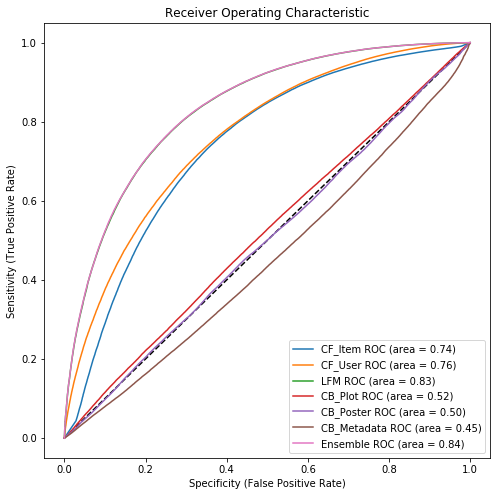

In [14]:
analysis_1_scores = get_metrics_df(test_preds_df, roc_outfile='../results/analysis_1_roc_plot.png', roc_thresholds=[2, 2.5, 3, 3.5, 4], rmse_thresholds=[0, 2, 2.5, 3, 3.5, 4])

In [15]:
# TODO: Order the rows correctly, rename the columns, add ROC_AUC@[2:4] in google sheet, and convert it to latex.
analysis_1_scores

,ROC_AUC @ 2,ROC_AUC @ 2.5,ROC_AUC @ 3,ROC_AUC @ 3.5,ROC_AUC @ 4,RMSE @ 0,RMSE @ 2,RMSE @ 2.5,RMSE @ 3,RMSE @ 3.5,RMSE @ 4
CB_Metadata,0.451326,0.454771,0.448876,0.464246,0.453295,1.698341,1.445424,1.269466,1.176417,0.840956,0.662117
CB_Plot,0.531329,0.522835,0.516730,0.514225,0.506303,1.647678,1.666204,1.726861,1.773807,1.997946,2.140179
CB_Poster,0.505373,0.499846,0.499096,0.494155,0.493748,1.147200,1.011910,0.973255,0.974915,1.080935,1.184272
CF_Item,0.755485,0.745007,0.738955,0.727778,0.721198,1.041197,0.936451,0.893492,0.879754,0.888731,0.910298
CF_User,0.783897,0.767147,0.762206,0.747685,0.738719,0.938276,0.826585,0.783377,0.775277,0.801574,0.847452
Ensemble,0.853966,0.836120,0.835609,0.812100,0.812169,0.819420,0.718715,0.677400,0.671326,0.689691,0.731829
LFM,0.853048,0.835513,0.834955,0.812217,0.811990,0.821082,0.715190,0.672349,0.666211,0.689563,0.735681


# Analysis 2: Aspect specific regime exploration

In [18]:
genre_val_preds_df = copy.copy(val_preds_df_orig)
genre_val_preds_df['genre_aspect_qcut'] = genre_val_preds_df.apply(get_genre_aspect_qcut, axis=1)
genre_val_preds_df = genre_val_preds_df[pd.notnull(genre_val_preds_df['genre_aspect_qcut'])]

In [19]:
val_preds_df = copy.copy(val_preds_df_orig)
val_preds_df['user_aspect_qcut'] = val_preds_df.apply(get_user_aspect_qcut, axis=1)
val_preds_df['movie_aspect_qcut'] = val_preds_df.apply(get_movie_aspect_qcut, axis=1)

In [20]:
genre_test_preds_df = copy.copy(test_preds_df)
genre_test_preds_df['genre_aspect_qcut'] = genre_test_preds_df.apply(get_genre_aspect_qcut, axis=1)
genre_test_preds_df = genre_test_preds_df[pd.notnull(genre_test_preds_df['genre_aspect_qcut'])]

In [21]:
test_preds_df['user_aspect_qcut'] = test_preds_df.apply(get_user_aspect_qcut, axis=1)
test_preds_df['movie_aspect_qcut'] = test_preds_df.apply(get_movie_aspect_qcut, axis=1)

In [22]:
test_preds_df.head()

,user_id,movie_id,y_true,CF_Item,CF_User,LFM,CB_Plot,CB_Poster,CB_Metadata,Ensemble,user_aspect_qcut,movie_aspect_qcut
0,104816,1458,4.0,3.550149,3.232350,3.545094,2.386384,3.101215,4.881664,3.573447,7,9
1,104816,1475,3.0,3.695287,3.649180,3.377484,2.102922,3.254157,4.884876,3.339065,7,9
2,104816,10,3.5,3.733033,3.776863,3.654338,2.434127,3.443481,4.800959,3.669746,7,9
3,104816,4667,3.0,3.404756,4.045578,3.388934,2.466457,3.383992,4.888978,3.355343,7,9
4,104817,294,4.0,4.690845,4.243420,4.294102,1.800061,3.696492,4.880144,4.311046,4,9


In [32]:
def plot_aspect_exploration(cur_df, qcut_col, qcut_values, primary_metric, x_label, outfile, model_col_names, title=None):
    y_values_dict = defaultdict(list)
    nan_x_values = []
    for qcut_val in qcut_values:
        cur_sub_df = cur_df.loc[cur_df[qcut_col] == qcut_val]
        if len(cur_sub_df) < 1:
            nan_x_values.append(qcut_val)
            continue

        try:
            cur_metrics_dict = get_metrics_df(cur_sub_df).to_dict()
        except Exception as e:
            print("[WARNING] Couldn't calculate metrics for qcut_val: %s due to \n%s" % (qcut_val, str(e)))
            nan_x_values.append(qcut_val)
            continue

        model_to_score_dict = cur_metrics_dict[primary_metric]
        for model in model_col_names:
            score = model_to_score_dict[model]
            y_values_dict[model].append(score)

    plt.rcParams['figure.figsize'] = [15, 8]
    x_values = [x for x in qcut_values if x not in nan_x_values]
    for model, y_values in y_values_dict.items():
        plt.plot(x_values, y_values, label=model)

    plt.xlabel(x_label)
    plt.ylabel(primary_metric)
    plt.xticks(qcut_values)
    plt.legend()

    if title:
        plt.title(title)

    plt.savefig(outfile)


In [25]:
# Trains on val_df using RidgeCV and predicts and appends to test_df.
def get_aspect_case_wise_model(cur_val_df, cur_test_df, qcut_col, qcut_values, model_col_names, model_name, default_pred_col="Ensemble"):
    def _train_and_get_ensemble(cur_val_preds_df):
        X_train = cur_val_preds_df[model_col_names].values
        y_train = cur_val_preds_df['y_true'].values

        n = len(y_train)
        if n > 100:
            ensemble_model = RidgeCV(normalize=True, alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(X_train, y_train)
        else:
            ensemble_model = RidgeCV(normalize=True, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

        print("Trained Ridge ensemble model with optimal alpha found: %s" % ensemble_model.alpha_)
        print("Ensemble features: %s" % model_col_names)
        print("Ensemble model coefficients: %s" % ensemble_model.coef_)
        return ensemble_model

    qcut_val_to_ensemble_model_dict = {}
    for qcut_val in qcut_values:
        cur_sub_val_df = cur_val_df.loc[cur_val_df[qcut_col] == qcut_val]
        if len(cur_sub_val_df) < 1:
            qcut_val_to_ensemble_model_dict[qcut_val] = None
            continue

        print("Getting ensemble model for qcut_val: %s" % qcut_val)
        cur_ensemble_model = _train_and_get_ensemble(cur_sub_val_df)
        qcut_val_to_ensemble_model_dict[qcut_val] = cur_ensemble_model

    def _get_case_wise_ensemble_preds(row):
        cur_model = qcut_val_to_ensemble_model_dict[row[qcut_col]]
        if cur_model is None:
            return row[default_pred_col]
    
        cur_X_test = np.array([row[model_col_names].values])
        cur_pred = cur_model.predict(cur_X_test)[0]
        return cur_pred

    cur_test_df = copy.copy(cur_test_df)
    cur_test_df[model_name] = cur_test_df.apply(_get_case_wise_ensemble_preds, axis=1)
    return cur_test_df


### User Aspect (Percentiles)

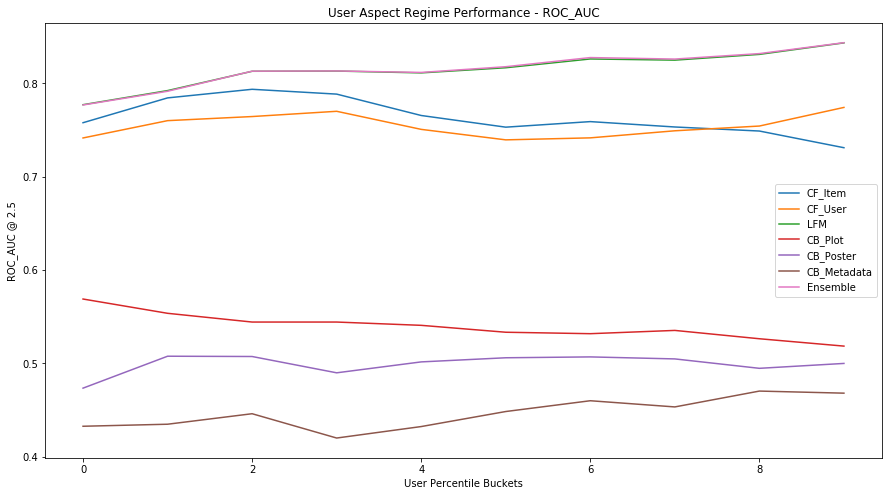

In [26]:
cur_df = test_preds_df
qcut_col = "user_aspect_qcut"
qcut_values = list(range(10))
primary_metric = "ROC_AUC @ 2.5"
x_label = "User Buckets at each Decile"
outfile = "../results/user_aspect_plot_roc.png"
title = "User Aspect Regime Performance - ROC_AUC @ 2.5"

plot_aspect_exploration(cur_df, qcut_col, qcut_values, primary_metric, x_label, outfile, model_col_names, title=title)

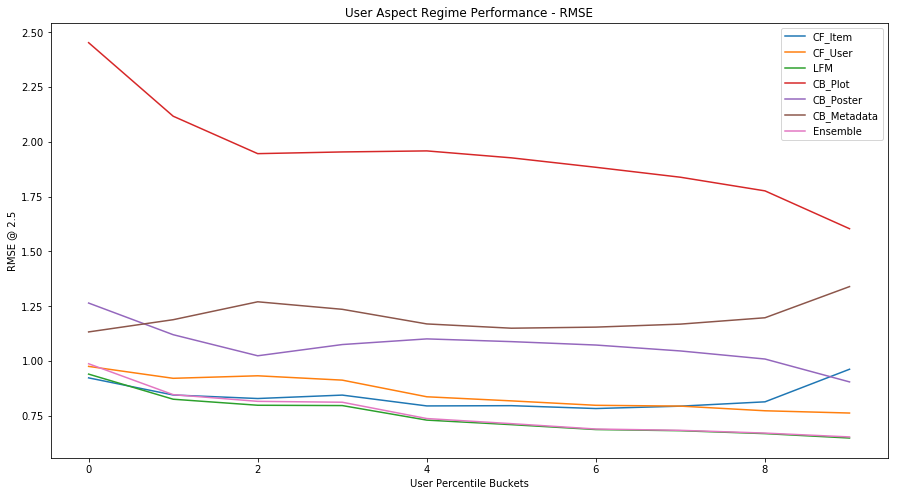

In [27]:
cur_df = test_preds_df
qcut_col = "user_aspect_qcut"
qcut_values = list(range(10))
primary_metric = "RMSE @ 2.5"
x_label = "User Buckets at each Decile"
outfile = "../results/user_aspect_plot_rmse.png"
title = "User Aspect Regime Performance - RMSE @ 2.5"

plot_aspect_exploration(cur_df, qcut_col, qcut_values, primary_metric, x_label, outfile, model_col_names, title=title)

In [28]:
# Building User-Aspect case-wise model.
cur_val_df = val_preds_df
cur_test_df = test_preds_df
qcut_col = "user_aspect_qcut"
qcut_values = list(range(10))
model_name = "Ensemble_UserAspect"

test_preds_df = get_aspect_case_wise_model(cur_val_df, cur_test_df, qcut_col, qcut_values, model_col_names_orig, model_name)

Getting ensemble model for qcut_val: 0
Trained Ridge ensemble model with optimal alpha found: 0.01
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [ 0.21297835  0.1005091   0.40588681 -0.05370976 -0.13198484 -0.31346735]
Getting ensemble model for qcut_val: 1
Trained Ridge ensemble model with optimal alpha found: 0.001
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [ 0.08262932  0.08010354  0.6676227   0.07629164  0.04910545 -0.08157717]
Getting ensemble model for qcut_val: 2
Trained Ridge ensemble model with optimal alpha found: 0.001
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [ 0.11414242  0.01317643  0.75308737  0.14757105  0.01054712 -0.12814463]
Getting ensemble model for qcut_val: 3
Trained Ridge ensemble model with optimal alpha found: 0.001
Ensemble features: ['CF_Item

In [29]:
test_preds_df.head()

,user_id,movie_id,y_true,CF_Item,CF_User,LFM,CB_Plot,CB_Poster,CB_Metadata,Ensemble,user_aspect_qcut,movie_aspect_qcut,Ensemble_UserAspect
0,104816,1458,4.0,3.550149,3.232350,3.545094,2.386384,3.101215,4.881664,3.573447,7,9,3.580212
1,104816,1475,3.0,3.695287,3.649180,3.377484,2.102922,3.254157,4.884876,3.339065,7,9,3.318866
2,104816,10,3.5,3.733033,3.776863,3.654338,2.434127,3.443481,4.800959,3.669746,7,9,3.671308
3,104816,4667,3.0,3.404756,4.045578,3.388934,2.466457,3.383992,4.888978,3.355343,7,9,3.351467
4,104817,294,4.0,4.690845,4.243420,4.294102,1.800061,3.696492,4.880144,4.311046,4,9,4.261985


### Movie Aspect (Percentiles)

[WARNING] Couldn't calculate metrics for qcut_val: 1 due to 
Only one class present in y_true. ROC AUC score is not defined in that case.


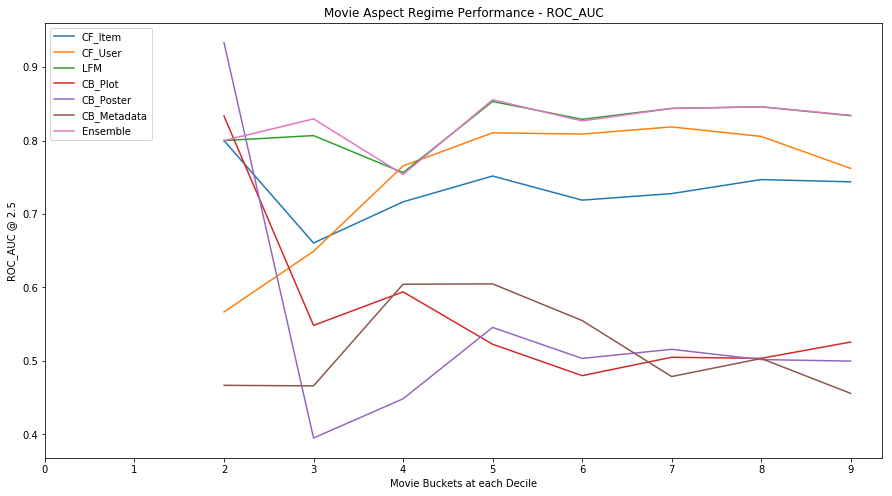

In [33]:
cur_df = test_preds_df
qcut_col = "movie_aspect_qcut"
qcut_values = list(range(10))
primary_metric = "ROC_AUC @ 2.5"
x_label = "Movie Buckets at each Decile"
outfile = "../results/movie_aspect_plot_roc.png"
title = "Movie Aspect Regime Performance - ROC_AUC @ 2.5"

plot_aspect_exploration(cur_df, qcut_col, qcut_values, primary_metric, x_label, outfile, model_col_names, title=title)

[WARNING] Couldn't calculate metrics for qcut_val: 1 due to 
Only one class present in y_true. ROC AUC score is not defined in that case.


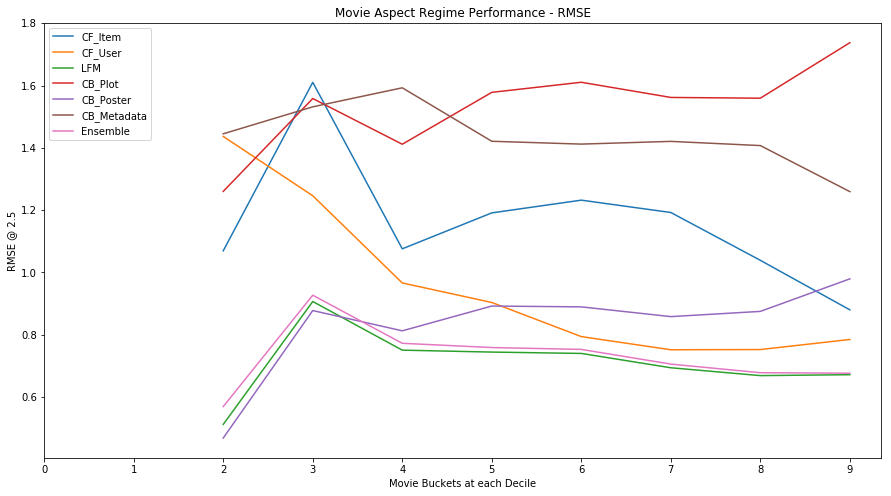

In [34]:
cur_df = test_preds_df
qcut_col = "movie_aspect_qcut"
qcut_values = list(range(10))
primary_metric = "RMSE @ 2.5"
x_label = "Movie Buckets at each Decile"
outfile = "../results/movie_aspect_plot_rmse.png"
title = "Movie Aspect Regime Performance - RMSE @ 2.5"

plot_aspect_exploration(cur_df, qcut_col, qcut_values, primary_metric, x_label, outfile, model_col_names, title=title)

In [ ]:
# Building Movie-Aspect case-wise model.
cur_val_df = val_preds_df
cur_test_df = test_preds_df
qcut_col = "movie_aspect_qcut"
qcut_values = list(range(10))
model_name = "Ensemble_MovieAspect"

test_preds_df = get_aspect_case_wise_model(cur_val_df, cur_test_df, qcut_col, qcut_values, model_col_names_orig, model_name)

Getting ensemble model for qcut_val: 1
Trained Ridge ensemble model with optimal alpha found: 0.001
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [0. 0. 0. 0. 0. 0.]
Getting ensemble model for qcut_val: 2
Trained Ridge ensemble model with optimal alpha found: 1.0
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [ 0.06692948  0.27442633  0.20557812  0.03546136 -0.05266904  2.70920454]
Getting ensemble model for qcut_val: 3
Trained Ridge ensemble model with optimal alpha found: 1.0
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [ 0.14803904  0.09236832  0.35222012  0.16491486 -0.12092107 -1.17698969]
Getting ensemble model for qcut_val: 4
Trained Ridge ensemble model with optimal alpha found: 0.1
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']

/home/bhuvan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/home/bhuvan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Getting ensemble model for qcut_val: 9
Trained Ridge ensemble model with optimal alpha found: 0.001
Ensemble features: ['CF_Item', 'CF_User', 'LFM', 'CB_Plot', 'CB_Poster', 'CB_Metadata']
Ensemble model coefficients: [-0.01110329 -0.07367003  1.13717335  0.07438868  0.0156139  -0.01783214]


In [ ]:
test_preds_df.head()

### Genre Aspect (Categorical)

In [ ]:
cur_df = genre_test_preds_df
qcut_col = "genre_aspect_qcut"
primary_metric = "ROC_AUC @ 2.5"
outfile = "../results/genre_aspect_plot_roc.png"
title = "Genre Aspect Regime Performance - ROC_AUC"

#plot_aspect_exploration(cur_df, qcut_col, genre_qcut_values, primary_metric, outfile, model_col_names, title=title)

In [ ]:
cur_df = genre_test_preds_df
qcut_col = "genre_aspect_qcut"
primary_metric = "RMSE @ 2.5"
outfile = "../results/genre_aspect_plot_rmse.png"
title = "Genre Aspect Regime Performance - RMSE"

#plot_aspect_exploration(cur_df, qcut_col, genre_qcut_values, primary_metric, outfile, model_col_names, title=title)

# Final Results for all ensemble models.

In [55]:
analysis_1_scores_withAspectWiseModels

,roc_auc_at_2,roc_auc_at_2.5,roc_auc_at_3,roc_auc_at_3.5,roc_auc_at_4,rmse_at_0,rmse_at_2,rmse_at_2.5,rmse_at_3,rmse_at_3.5,rmse_at_4
CB_Plot,0.488061,0.486981,0.482122,0.488304,0.479935,1.685106,1.704382,1.765856,1.812947,2.039785,2.182764
CB_Poster,0.501220,0.498963,0.497026,0.498197,0.496317,1.145249,1.010488,0.971810,0.972925,1.078919,1.180389
CF_Item,0.754719,0.745329,0.738709,0.728444,0.721284,1.036728,0.931185,0.888089,0.874164,0.882816,0.904652
CF_User,0.783056,0.766093,0.760726,0.746923,0.737321,0.938195,0.826754,0.783267,0.775016,0.801555,0.846764
Ensemble,0.853314,0.836012,0.835309,0.812054,0.811903,0.818457,0.718125,0.676876,0.670640,0.688447,0.729792
Ensemble_MovieAspect,0.853397,0.836088,0.835401,0.812114,0.811973,0.818314,0.718031,0.676781,0.670539,0.688265,0.729579
Ensemble_UserAspect,0.853382,0.836212,0.835751,0.812693,0.812414,0.817446,0.717191,0.675965,0.669686,0.687234,0.727963
LFM,0.852774,0.835742,0.834862,0.812468,0.811754,0.819914,0.714356,0.671417,0.665010,0.687557,0.732747
movie_aspect_qcut,0.514103,0.510918,0.511562,0.507580,0.509377,5.516642,5.322641,5.175027,5.094648,4.779304,4.610825
user_aspect_qcut,0.479846,0.470111,0.450856,0.470878,0.443678,4.782480,4.595034,4.445373,4.346650,4.060179,3.833289


In [57]:
analysis_1_scores_withAspectWiseModels = get_metrics_df(test_preds_df.drop(columns=['movie_aspect_qcut', 'user_aspect_qcut', 'genre_aspect_qcut']), roc_outfile='../results/analysis_1_roc_plot_withAspectWiseModels.png', roc_thresholds=[2, 2.5, 3, 3.5, 4], rmse_thresholds=[0, 2, 2.5, 3, 3.5, 4])

KeyError: "['genre_aspect_qcut'] not found in axis"